# Phase 3 Data Science Training Notebook

In [427]:
import pandas as pd
import numpy as np

## Exploratory Data Analysis

In [428]:
# Assume tar.gz file to be extracted at project directory.
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [429]:
data_batch_1 = unpickle("data_batch_1")
data_batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [430]:
labelNames = unpickle("batches.meta")
labelNames.keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [431]:
print(labelNames[b'num_cases_per_batch'])
print(labelNames[b'label_names'])
labelNames.values()

10000
[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


dict_values([10000, [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], 3072])

In [432]:
labelList = labelNames[b'label_names']

In [433]:
data_batch_1[b'batch_label']

b'training batch 1 of 5'

In [434]:
print(len(data_batch_1[b'labels']))
print(max(data_batch_1[b'labels']))
print(min(data_batch_1[b'labels']))
labels = data_batch_1[b'labels']

10000
9
0


In [435]:
indexForEach = []
for i in range (10):
    temp = []
    for idx, label in enumerate(labels):
        if len(temp) == 5:
            indexForEach.append(temp)
            break
        if label == i:
            temp.append(idx)

indexForEach

[[29, 30, 35, 49, 77],
 [4, 5, 32, 44, 45],
 [6, 13, 18, 24, 41],
 [9, 17, 21, 26, 33],
 [3, 10, 20, 28, 34],
 [27, 40, 51, 56, 70],
 [0, 19, 22, 23, 25],
 [7, 11, 12, 37, 43],
 [8, 62, 69, 92, 100],
 [1, 2, 14, 15, 16]]

In [436]:
data_batch_1[b'data'].shape

(10000, 3072)

In [437]:
import matplotlib.pyplot as plt

def getFiveImages(toShow, index):
    sampleImages = []
    for i in range (5):
        temp =  data_batch_1[b'data'][toShow[i]]
        temp = temp.reshape(3,32,32)
        temp = temp.transpose(1,2,0)
        sampleImages.append(temp)
    fig, axs = plt.subplots(1, 5, constrained_layout=True)
    fig.suptitle("Label " + index + " (" + str(labelList[int(index)]).replace("b'", "").replace("'", "") + ")", fontsize=16)
    fig.set_figwidth(15)
    for j in range (5):
        axs[j].imshow(sampleImages[j])

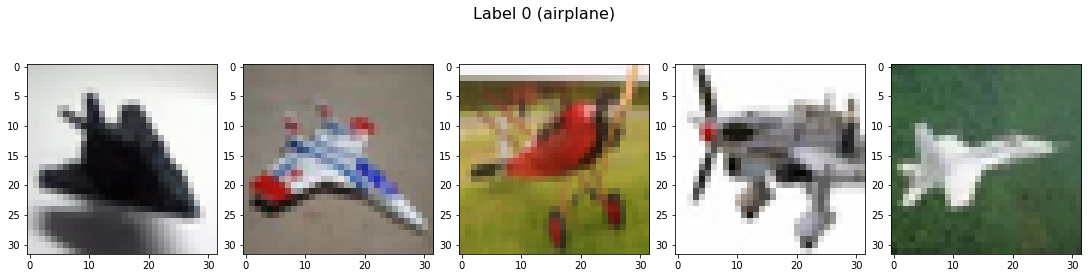

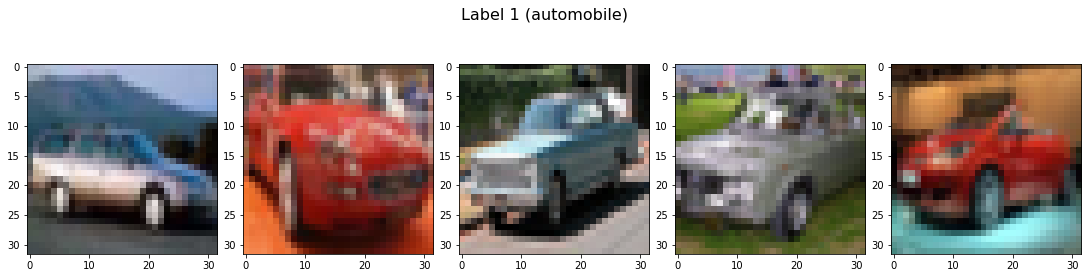

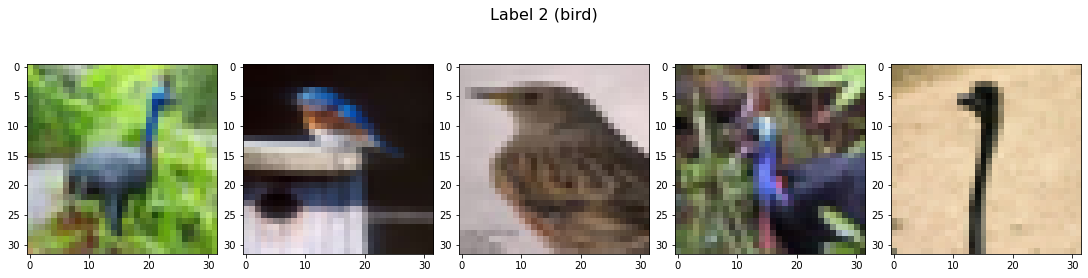

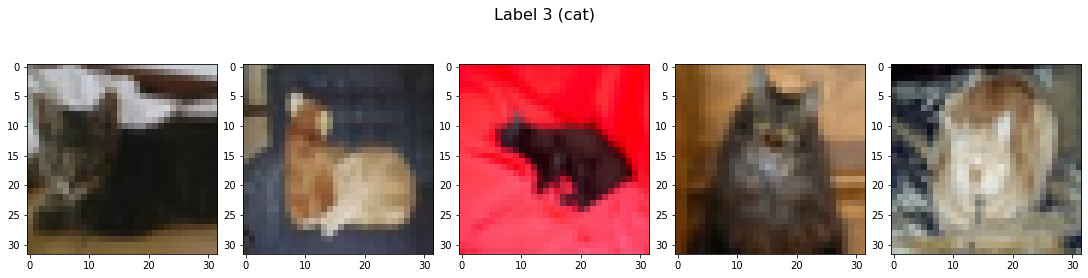

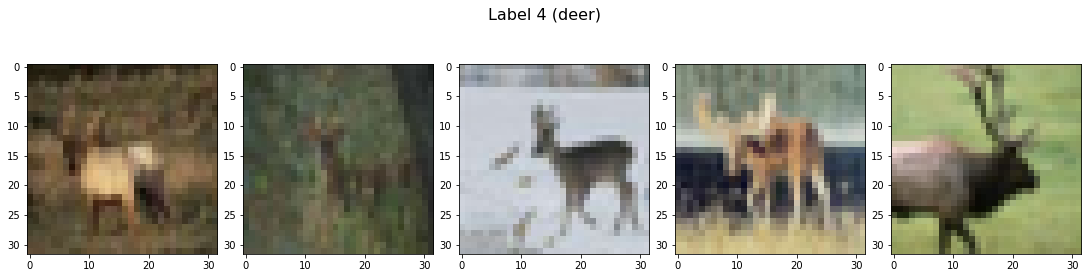

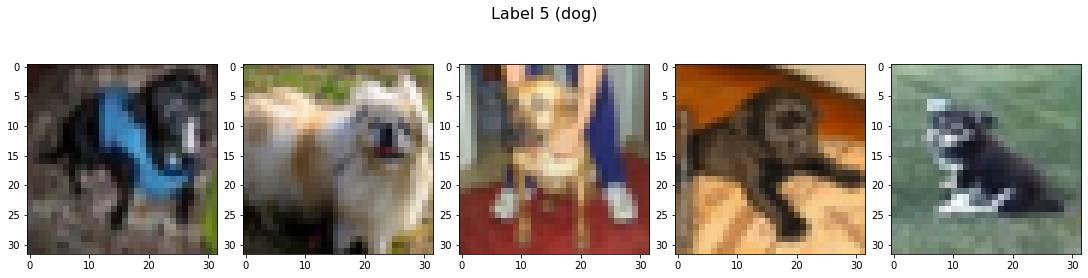

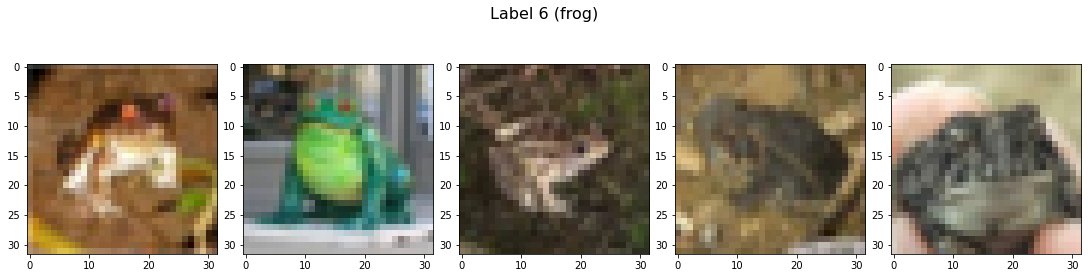

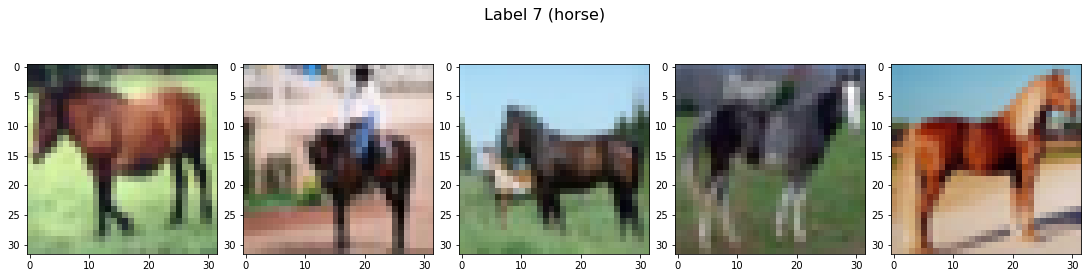

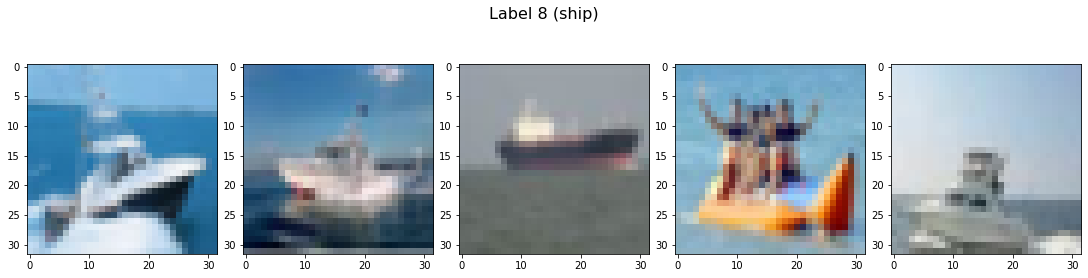

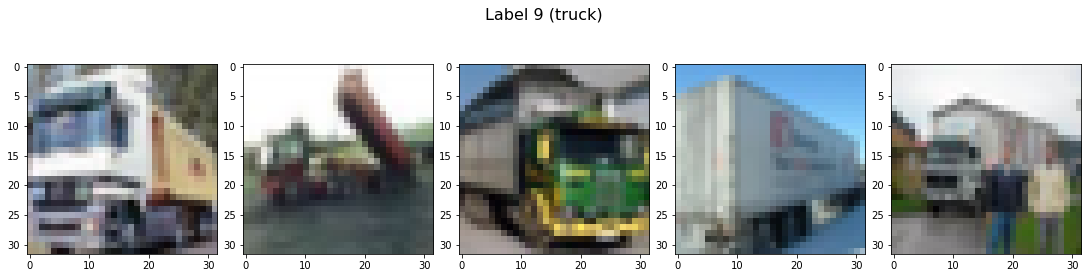

In [438]:
for i in range (10):
    getFiveImages(indexForEach[i], str(i))

I'd like to use label 2, which appears to be birds

# Data Processing

Now lets unpickle the rest of the files and then see how we can use it to fit a model

In [439]:
testingData = unpickle("test_batch")
data_batch_2 = unpickle("data_batch_2")
data_batch_3 = unpickle("data_batch_3")
data_batch_4 = unpickle("data_batch_4")
data_batch_5 = unpickle("data_batch_5")


To avoid data imbalance, ideally we will have an even amount of each of the labels, all sampled from the different datasets. 

In [440]:
print(len(testingData[b'labels']))
testingData[b'labels'].count(2)



10000


1000

In [441]:
batches = []
batches.append(data_batch_1)
batches.append(data_batch_2)
batches.append(data_batch_3)
batches.append(data_batch_4)
batches.append(data_batch_5)

In [442]:
def formatData(entry):
    temp = entry
    temp = temp.reshape(3,32,32)
    temp = temp.transpose(1,2,0)
    return temp

We need to make the target variable either 1 or 0 based on whether the image in fact belongs to the label that we are interested in

In [443]:
def formatLabels(correct, label):
    if label == correct:
        return 1
    else:
        return 0

In [444]:
combinedTrainData = batches[0][b'data']
combinedTrainLabels = batches[0][b'labels']
for i in range (1,5):
    combinedTrainLabels = np.concatenate((combinedTrainLabels, batches[i][b'labels']))
    combinedTrainData = np.concatenate((combinedTrainData, batches[i][b'data']))
print(len(combinedTrainData))
print(len(combinedTrainLabels))

50000
50000


In [445]:
#for idx, label in enumerate(trainingLabels):
 #   trainingLabels[idx] = formatLabels(2, label) #change to binary

we should check that there is no data imbalance(ie our target is not overrepresented in the data).

In [446]:
list(trainingLabels).count(1) 

5000

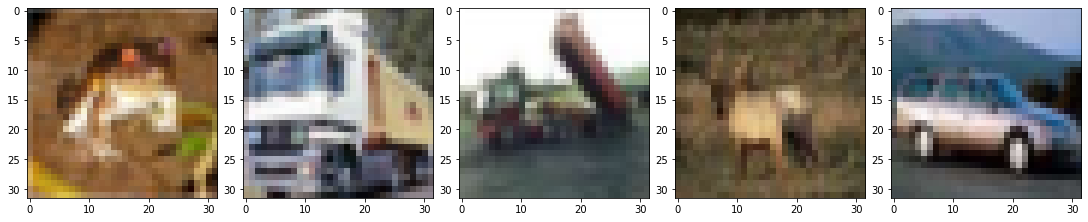

In [447]:
testImages = []
trainImages = []
for val in combinedTrainData:
    trainImages.append(formatData(val)) #getting the correct format to display image
for val in testingData[b'data']:
    testImages.append(formatData(val))


fig, axs = plt.subplots(1, 5, constrained_layout=True)
fig.set_figwidth(15)
for j in range (5):
    axs[j].imshow(trainImages[j])

In [448]:
trainingData = np.array(trainImages)
trainingLabels = np.array(combinedTrainLabels)

In [449]:
from keras.utils import to_categorical


train_x = trainingData
train_y = to_categorical(trainingLabels)
print(train_y)
test_x = np.array(testImages)
test_y = to_categorical(np.array(testingData[b'labels']))



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


# Data Modelling

In [450]:
import tensorflow as tf
from tensorflow.keras import Input, Sequential, optimizers, losses, callbacks
from datetime import datetime
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Rescaling
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.optimizers import SGD
from tensorboard.plugins.hparams import api as hp


In [451]:
log_dir = "output/logs/" + datetime.now().strftime("%Y-%m-%d-%H%M%S")

In [452]:
HP_OPTIMIZER = hp.HParam('optimzer', hp.Discrete(['adam', 'sgd']))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2,0.8))
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_OPTIMIZER,HP_DROPOUT],
        metrics=[hp.Metric('accuracy', display_name='accuracy')]
    )

In [460]:
def trainTestModel(hparams):
    model = Sequential(name="Image_Recognition_Model")
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Rescaling(scale=1./255, name="Normaliser")) # Example pre-processing layer.
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=hparams[HP_OPTIMIZER],
                loss=losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
    model.fit(train_x, train_y,
    batch_size=64,
    epochs=1,
    )
    _,accuracy = model.evaluate(test_x, test_y)
    return accuracy

In [454]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = trainTestModel(hparams)
    tf.summary.scalar('accuracy', accuracy, step=1)

In [462]:
session = 0
dropoutRate = HP_DROPOUT.domain.min_value
while dropoutRate <= HP_DROPOUT.domain.max_value:
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
            HP_DROPOUT: dropoutRate,
            HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session
        print("%s" % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('output/logs/hparam_tuning/' + run_name, hparams)
        session+=1
        
    dropoutRate += 0.1
                

run-0
{'dropout': 0.2, 'optimzer': 'adam'}
313/313 [==============================] - 7s 21ms/step - loss: 1.0757 - accuracy: 0.6174
run-1
{'dropout': 0.2, 'optimzer': 'sgd'}
313/313 [==============================] - 6s 20ms/step - loss: 1.8927 - accuracy: 0.3768
run-2
{'dropout': 0.30000000000000004, 'optimzer': 'adam'}
313/313 [==============================] - 7s 21ms/step - loss: 1.1441 - accuracy: 0.6004
run-3
{'dropout': 0.30000000000000004, 'optimzer': 'sgd'}
313/313 [==============================] - 5s 15ms/step - loss: 1.5737 - accuracy: 0.4444
run-4
{'dropout': 0.4, 'optimzer': 'adam'}
313/313 [==============================] - 5s 17ms/step - loss: 1.1836 - accuracy: 0.5781
run-5
{'dropout': 0.4, 'optimzer': 'sgd'}
313/313 [==============================] - 5s 17ms/step - loss: 1.5373 - accuracy: 0.4459
run-6
{'dropout': 0.5, 'optimzer': 'adam'}
313/313 [==============================] - 5s 16ms/step - loss: 1.2351 - accuracy: 0.5516
run-7
{'dropout': 0.5, 'optimzer': 'sgd'

Using the data, we can see that adam optimiser with 0.2 dropout seems to yield the best results

In [463]:
def generateModel():
    
    model = Sequential(name="Image_Recognition_Model")
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Rescaling(scale=1./255, name="Normaliser")) # Example pre-processing layer.
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                loss=losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

In [464]:
model = generateModel()

# Callbacks for QoL.
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
model.fit(train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=30,
    batch_size=64, 
    callbacks=[tensorboard_callback, earlystop_callback],
)

model.save('final_model.h5')

Epoch 1/30
782/782 [==============================] - 91s 116ms/step - loss: 1.4228 - accuracy: 0.4858 - val_loss: 1.0494 - val_accuracy: 0.6194
Epoch 2/30
782/782 [==============================] - 86s 110ms/step - loss: 0.9926 - accuracy: 0.6510 - val_loss: 0.9279 - val_accuracy: 0.6739
Epoch 3/30
782/782 [==============================] - 86s 110ms/step - loss: 0.8197 - accuracy: 0.7134 - val_loss: 0.8079 - val_accuracy: 0.7231
Epoch 4/30
782/782 [==============================] - 85s 108ms/step - loss: 0.7026 - accuracy: 0.7549 - val_loss: 0.7561 - val_accuracy: 0.7415
Epoch 5/30
782/782 [==============================] - 93s 119ms/step - loss: 0.6147 - accuracy: 0.7835 - val_loss: 0.7383 - val_accuracy: 0.7480
Epoch 6/30
782/782 [==============================] - 92s 117ms/step - loss: 0.5381 - accuracy: 0.8107 - val_loss: 0.7519 - val_accuracy: 0.7473
Epoch 7/30
782/782 [==============================] - 90s 116ms/step - loss: 0.4822 - accuracy: 0.8295 - val_loss: 0.7750 - val_ac

In [470]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
 
def loadImage(filename):
	img = load_img(filename, target_size=(32, 32))
	img = img_to_array(img)
	img = img.reshape(1, 32, 32, 3)
	img = img 
	return img

def predictForImage(label):
	img = loadImage('bird.png')
	# load model
	model = load_model('final_model.h5')
	result = model.predict(img)
	mostProbIndex = np.argmax(result, axis=-1)
	print(mostProbIndex)
	print(result[0][label])
	print("It's most likely: ", labelNames[b'label_names'][mostProbIndex[0]])

predictForImage(1)

1/1 [==============================] - 0s 72ms/step
[2]
0.000114680915
It's most likely:  b'bird'
